In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from utils import *

In [2]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

df_bitcoin = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df_tesla = pd.read_csv("csv/articles_Tesla-Elon_Musk_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df = df_bitcoin

In [3]:
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"

stocks = ["TSLA"]
keywords = {"TSLA": ["Tesla", "Elon Musk"]}
stocks = ["BTC-USD"]
keywords = {"BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
prices = df_financial["Close"]

In [4]:
prices = pd.DataFrame(data = prices, index = pd.date_range(start,end)).fillna(method = "bfill")

### Split sentences

In [5]:
# titles and descriptions
titles = df.title
titles.index = df["date_google"]
descriptions = df.description
descriptions.index = df["date_google"]
text = pd.concat([titles,descriptions]).sort_index().dropna()

In [28]:
# main_text
text = df.maintext #pd.DataFrame(df.maintext.values, index = df["date_google"]).dropna()
text.index = df["date_google"]

In [6]:
import nltk.data

split_sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
split_sentences = text.apply(split_sentence_tokenizer.tokenize)
split_sentences = split_sentences.groupby(split_sentences.index).sum()
split_sentences = pd.DataFrame(split_sentences)

In [8]:
BERT_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(BERT_URL, trainable=False)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

In [9]:
keywords_bitcoin = ["crypto", "BTC", "bitcoin", "blockchain"]
keywords_tesla =   ["tesla", "Elon", "Musk", "TSLA"]
raw_text = "".join(text.values).replace(".com","-com").replace(".", "").replace(",", "").replace("\n", " ").replace("-com",".com")
new_tokens = find_new_token_with_custom_keywords(raw_text, keywords_bitcoin, 6, ["btc"])

New tokens to be added:  ['bitcoin', 'cryptocurrency', 'crypto', 'cryptocurrencies', 'blockchain', 'bitcoin’s', 'btc']


In [10]:
tokenizer = create_tokenizer(vocab_file)
tokenizer = add_new_tokens(new_tokens, tokenizer)

In [11]:
df_ret = label_transformer(prices.copy(), shift = 1)

split_sentences, df_ret = series_intersection(split_sentences, df_ret)
raw_sentences, raw_labels = generate_data_for_tokenizer(split_sentences,df_ret)

lengths = raw_sentences.apply(lambda x: len(x[0].split()), axis = 1)
sentences = raw_sentences[(lengths > 10) & (lengths < 120)] #filter short and long sentences
labels = raw_labels[(lengths > 10) & (lengths < 120)]

threshold = "2020-01-01"
train_sentences = sentences.loc[:"2019-12-31"]
test_sentences = sentences.loc["2020-01-01":]
train_labels = labels.loc[:"2019-12-31"]
test_labels = labels.loc["2020-01-01":]

In [12]:
train_labels.shape

(2618, 1)

[]

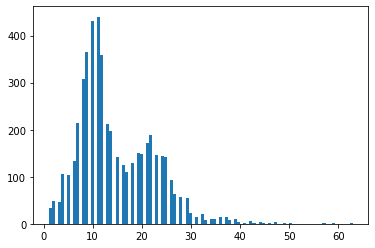

In [13]:
plt.hist(lengths, bins = 100)
plt.plot()

In [14]:
print(train_sentences.values[0])
print(tokenizer.tokenize(train_sentences.values[0][0]))

['Extrapolating on crypto’s first decade: How does BTC performance correlate with that of gold, tech stocks and other traditional assets?']
['extra', '##pol', '##ating', 'on', 'crypto', '’', 's', 'first', 'decade', ':', 'how', 'does', 'btc', 'performance', 'co', '##rre', '##late', 'with', 'that', 'of', 'gold', ',', 'tech', 'stocks', 'and', 'other', 'traditional', 'assets', '?']


In [15]:
max_seq_length = 80
train_input_ids, train_input_masks, train_segment_ids = convert_sentences_to_features(train_sentences.values.flatten(), tokenizer, max_seq_length)
test_input_ids, test_input_masks, test_segment_ids = convert_sentences_to_features(test_sentences.values.flatten(), tokenizer, max_seq_length)


In [16]:
train_inputs = {
     "input_ids": np.array(train_input_ids),
     "input_mask": np.array(train_input_masks),
     "segment_ids": np.array(train_segment_ids),
     }


test_inputs = {
     "input_ids": np.array(test_input_ids),
     "input_mask": np.array(test_input_masks ),
     "segment_ids": np.array(test_segment_ids),
     }

In [1]:
import pickle

In [ ]:
pickle.dumps(train_inputs)

In [23]:
with open('train_inputs_bitcoin_articles.pickle', 'wb') as handle:
    pickle.dump(train_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('test_inputs_bitcoin_articles.pickle', 'wb') as handle:
    pickle.dump(test_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('train_inputs_bitcoin_articles.pickle', 'rb') as handle:
    train_inputs = pickle.load(handle)
with open('test_inputs_bitcoin_articles.pickle', 'rb') as handle:
    test_inputs = pickle.load(handle)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [3]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from utils import *

### BERT output

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [5]:
BERT_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(BERT_URL, trainable=False)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

In [7]:
max_seq_length = 120
# Build model
in_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
in_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
in_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]

# Instantiate the custom Bert Layer defined above
pooled_output, sequence_output = bert_layer(inputs = bert_inputs)
bert_outputs = [pooled_output, sequence_output]
bert_model = tf.keras.models.Model(inputs=bert_inputs, outputs=bert_outputs)
bert_model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
with open('train_inputs_bitcoin_articles.pickle', 'rb') as handle:
    train_inputs = pickle.load(handle)

In [9]:
train_bert_output = bert_model.predict(train_inputs, batch_size=64)

In [15]:
with open('test_inputs_bitcoin_articles.pickle', 'rb') as handle:
    test_inputs = pickle.load(handle)


In [16]:
test_bert_output = bert_model.predict(test_inputs, batch_size=256)

In [12]:
name = "bitcoin_articles"

In [13]:
np.save("features_labels/train_bert_{}_output_pooled".format(name),train_bert_output[0])
np.save("features_labels/train_bert_{}_output_sequence".format(name),train_bert_output[1])

In [17]:
np.save("features_labels/test_bert_{}_output_pooled".format(name),test_bert_output[0])
np.save("features_labels/test_bert_{}_output_sequence".format(name),test_bert_output[1])

In [36]:
label_name = "bitcoin_ret1days"
pd.to_pickle(train_labels, "features_labels/train_{}_labels".format(label_name))
pd.to_pickle(test_labels, "features_labels/test_{}_labels".format(label_name))

In [155]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [26]:
train_bert_output[0].shape

(40522, 768)

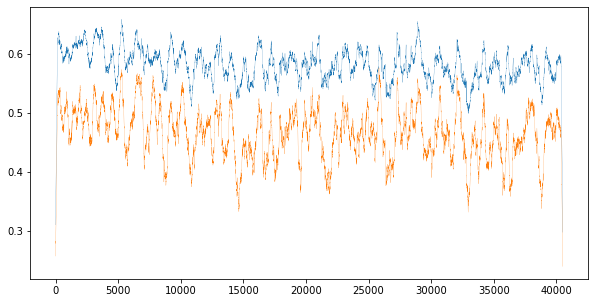

In [28]:
from random import randint
max_ = 768 # 40522
i = randint(0, max_)
i2 = randint(0, max_)
s = train_bert_output[0][:,i]
s2 = train_bert_output[0][:,i + 1]

plt.figure(figsize=(10, 5))
plt.plot(smooth(s,300), '-', lw=0.2)
plt.plot(smooth(s2,300), '-', lw=0.2)


In [308]:
train_bert_output[1].shape

(2584, 120, 768)

In [30]:
print(train_inputs["input_ids"].shape)
print(train_inputs["input_mask"].shape)
print(train_inputs["segment_ids"].shape)

(40522, 120)
(40522, 120)
(40522, 120)


Sentence ['Extrapolating on crypto’s first decade: How does BTC performance correlate with that of gold, tech stocks and other traditional assets?']
Text number of words:  20 20
Text number of tokens:  31

input_ids 
 [  101  4469 18155  5844  2006     3  1521  1055  2034  5476  1024  2129
  2515     7  2836  2522 14343 13806  2007  2008  1997  2751  1010  6627
 15768  1998  2060  3151  7045  1029   102     0     0     0     0     0
     0     0     0     0]
input_mask 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0]
segment_ids 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


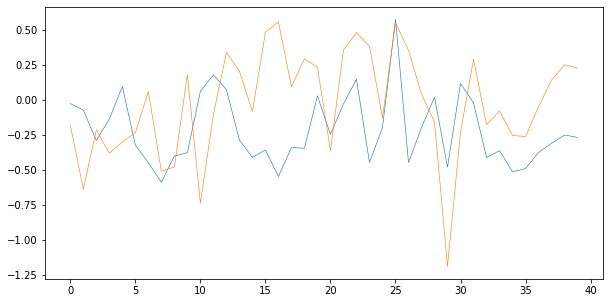

In [156]:
i = 0#randint(0, 40522)
text = train_sentences.values[i]
print("Sentence",text)
print("Text number of words: ", lengths[i], len(text[0].split(" ")))
print("Text number of tokens: ", train_inputs["input_mask"][i].sum())
print("\ninput_ids \n",train_inputs["input_ids"][i])
print("input_mask \n",train_inputs["input_mask"][i])
print("segment_ids \n",train_inputs["segment_ids"][i])

_120_1 = train_bert_output[1][i,:,1]
_120_2 = train_bert_output[1][i,:,2]
plt.figure(figsize=(10, 5))
plt.plot(smooth(_120_1,1), '-', lw=0.6)
plt.plot(smooth(_120_2,1), '-', lw=0.6)

In [59]:
train_bert_concat_articles = bert_output_to_one_time_series_per_day(...)
test_bert_concat_articles = bert_output_to_one_time_series_per_day(...)

In [60]:
np.save("features_labels/train_bert_concat_articles",train_bert_concat_articles)
np.save("features_labels/test_bert_concat_articles",test_bert_concat_articles)
train_labels.to_pickle("features_labels/train_labels")
test_labels.to_pickle("features_labels/test_labels")

27 32


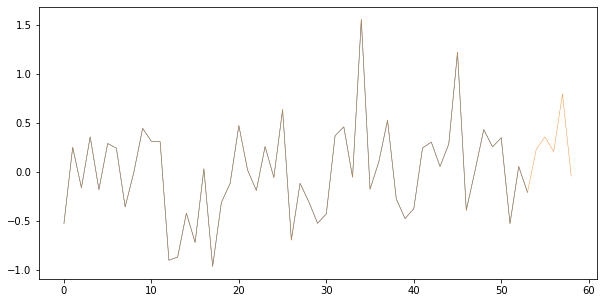

In [61]:
i = 0
mask_i = train_inputs["input_mask"][i].sum()
mask_i1 = train_inputs["input_mask"][i + 1].sum()
print(mask_i,mask_i1)
masked_sentence = train_bert_output[1][i,:mask_i,0]
masked_sentence1 = train_bert_output[1][i+1,:mask_i,0]
concat = np.append(masked_sentence,masked_sentence1)
plt.figure(figsize=(10, 5))
plt.plot(concat, '-', lw=0.6)
plt.plot(train_bert_concat_articles[0][:mask_i + mask_i1,0], '-', lw=0.4)

## LSTM

- https://ieeexplore.ieee.org/document/8141873
- https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
import pandas as pd, numpy as np

In [2]:
name = "bitcoin_articles"

In [5]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

np.load = np_load_old

In [17]:
train_inputs["input_ids"].shape

(40260, 120)

In [14]:
X_train_tr.shape

(40522, 768)

In [18]:
X_train_tr = train_bert_output[1]
X_test_tr = test_bert_output[1]

In [8]:
X_train_tr = np.load("features_labels/train_bert_{}_output_sequence.npy".format(name))
X_test_tr = np.load("features_labels/test_bert_{}_output_sequence.npy".format(name))

In [13]:
X_train_tr = np.load("features_labels/train_bert_output_{}_pooled.npy".format(name))
X_test_tr = np.load("features_labels/test_bert_output_{}_pooled.npy".format(name))

In [9]:
label_name = "bitcoin_ret1days"
train_labels = pd.read_pickle("features_labels/train_{}_labels".format(label_name))
test_labels = pd.read_pickle("features_labels/test_{}_labels".format(label_name))

In [10]:
print(X_train_tr.shape)
print(train_labels.shape)
print(X_test_tr.shape)
print(test_labels.shape)
y_train = train_labels.values
y_test = test_labels.values

(40260, 120, 768)
(40260, 1)
(8425, 120, 768)
(8425, 1)


In [11]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [12]:
X_train_tr, y_train = unison_shuffled_copies(X_train_tr, y_train)

In [13]:
y_train = np.where(y_train > 0, 1, 0)
y_test  = np.where(y_test  > 0, 1, 0)

In [14]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False )
y_train_ohe = ohe.fit_transform(y_train)
y_test_ohe = ohe.fit_transform(y_test)

In [49]:
import importlib
importlib.reload(tf)

<module 'tensorflow' from 'C:\\Users\\HPfamiliaRuiz-Tagle\\Anaconda3\\envs\\bert\\lib\\site-packages\\tensorflow\\__init__.py'>

In [47]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf

In [15]:
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.layers import Bidirectional, TimeDistributed, Dropout, BatchNormalization #, CuDNNLSTM
from tensorflow.keras.models import Sequential

In [52]:
%load_ext autoreload
%autoreload 2

In [17]:
from inception import Classifier_INCEPTION

In [54]:
X_train_tr = X_train_tr.reshape(X_train_tr.shape[0],1,X_train_tr.shape[1])
X_test_tr  = X_test_tr.reshape(X_test_tr.shape[0], 1,X_test_tr.shape[1])

ValueError: cannot reshape array of size 80424960 into shape (2618,1,40)

In [18]:
inception = Classifier_INCEPTION("models/",[None,768],2, verbose = True, nb_epochs = 1500)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 768)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     24576       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 768)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     40960       conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
hist = inception.fit(X_train_tr, y_train_ohe, X_test_tr, y_test_ohe, y_train, plot_test_acc=True)

Epoch 1/1500
630/630 [==============================] - 28s 45ms/step - loss: 0.6963 - accuracy: 0.5354 - val_loss: 0.6979 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 2/1500
630/630 [==============================] - 27s 43ms/step - loss: 0.6815 - accuracy: 0.5605 - val_loss: 0.7050 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 3/1500
630/630 [==============================] - 27s 42ms/step - loss: 0.6742 - accuracy: 0.5785 - val_loss: 0.7087 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 4/1500
630/630 [==============================] - 27s 43ms/step - loss: 0.6632 - accuracy: 0.5938 - val_loss: 0.7244 - val_accuracy: 0.5079 - lr: 0.0010
Epoch 5/1500
630/630 [==============================] - 27s 43ms/step - loss: 0.6500 - accuracy: 0.6173 - val_loss: 0.7328 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 6/1500
630/630 [==============================] - 27s 43ms/step - loss: 0.6346 - accuracy: 0.6367 - val_loss: 0.7420 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 7/1500
630/630 [========================

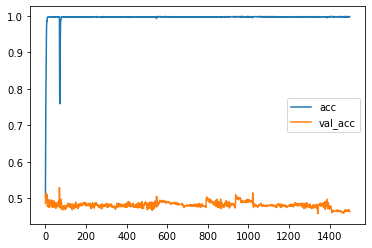

In [64]:
from matplotlib import pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.legend(["acc","val_acc"])
plt.show()

In [128]:
hist_first = hist

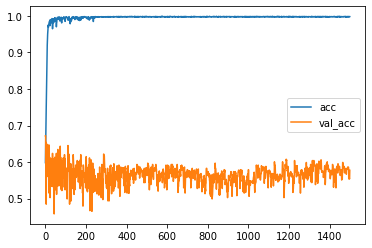

In [125]:
from matplotlib import pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.legend(["acc","val_acc"])
plt.show()

In [126]:
hist.history["val_accuracy"][-1]

0.5775400996208191

In [ ]:
inception.predict()

# OTHER MODELS

In [31]:
import tensorflow

In [422]:
# create the Dense Model

n_features = 768
model = Sequential()
model.add(Input(n_features))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss= "binary_crossentropy", optimizer='adam', metrics = ["acc"])
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 200)               153800    
_________________________________________________________________
dropout_95 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 200)               800       
_________________________________________________________________
dense_144 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_96 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 201       
Total params: 195,001
Trainable params: 194,601
Non-trainable params: 400
_____________________________________________

In [423]:
history = model.fit(X_train_tr, y_train, validation_data=(X_test_tr, y_test), epochs=100, batch_size=32)

Train on 2584 samples, validate on 623 samples
Epoch 1/100
2584/2584 [==============================] - ETA: 29s - loss: 0.9354 - acc: 0.53 - ETA: 1s - loss: 0.9286 - acc: 0.4779 - ETA: 0s - loss: 0.9303 - acc: 0.483 - ETA: 0s - loss: 0.9102 - acc: 0.487 - ETA: 0s - loss: 0.8932 - acc: 0.484 - 1s 275us/sample - loss: 0.8870 - acc: 0.4876 - val_loss: 0.7002 - val_acc: 0.4783
Epoch 2/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6541 - acc: 0.718 - ETA: 0s - loss: 0.8229 - acc: 0.526 - ETA: 0s - loss: 0.8129 - acc: 0.524 - ETA: 0s - loss: 0.8126 - acc: 0.509 - ETA: 0s - loss: 0.8133 - acc: 0.501 - 0s 109us/sample - loss: 0.8116 - acc: 0.5012 - val_loss: 0.7048 - val_acc: 0.5024
Epoch 3/100
2584/2584 [==============================] - ETA: 0s - loss: 0.9885 - acc: 0.406 - ETA: 0s - loss: 0.8339 - acc: 0.468 - ETA: 0s - loss: 0.7976 - acc: 0.508 - ETA: 0s - loss: 0.7933 - acc: 0.504 - ETA: 0s - loss: 0.7895 - acc: 0.505 - 0s 110us/sample - loss: 0.7852 - acc: 0.5112 - 

Epoch 50/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6829 - acc: 0.531 - ETA: 0s - loss: 0.7016 - acc: 0.483 - ETA: 0s - loss: 0.6951 - acc: 0.518 - ETA: 0s - loss: 0.6939 - acc: 0.522 - ETA: 0s - loss: 0.6934 - acc: 0.526 - 0s 112us/sample - loss: 0.6932 - acc: 0.5236 - val_loss: 0.7047 - val_acc: 0.5056
Epoch 51/100
2584/2584 [==============================] - ETA: 0s - loss: 0.7282 - acc: 0.375 - ETA: 0s - loss: 0.6982 - acc: 0.490 - ETA: 0s - loss: 0.6949 - acc: 0.503 - ETA: 0s - loss: 0.6962 - acc: 0.496 - ETA: 0s - loss: 0.6961 - acc: 0.503 - 0s 114us/sample - loss: 0.6952 - acc: 0.5043 - val_loss: 0.6954 - val_acc: 0.5169
Epoch 52/100
2584/2584 [==============================] - ETA: 0s - loss: 0.7025 - acc: 0.531 - ETA: 0s - loss: 0.6898 - acc: 0.529 - ETA: 0s - loss: 0.6947 - acc: 0.522 - ETA: 0s - loss: 0.6955 - acc: 0.514 - ETA: 0s - loss: 0.6944 - acc: 0.514 - 0s 111us/sample - loss: 0.6944 - acc: 0.5147 - val_loss: 0.6990 - val_acc: 0.4912
Epoch 53/1

Epoch 99/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6801 - acc: 0.593 - ETA: 0s - loss: 0.6867 - acc: 0.552 - ETA: 0s - loss: 0.6855 - acc: 0.554 - ETA: 0s - loss: 0.6851 - acc: 0.556 - ETA: 0s - loss: 0.6872 - acc: 0.551 - 0s 112us/sample - loss: 0.6874 - acc: 0.5499 - val_loss: 0.7021 - val_acc: 0.5169
Epoch 100/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6803 - acc: 0.656 - ETA: 0s - loss: 0.6902 - acc: 0.523 - ETA: 0s - loss: 0.6900 - acc: 0.525 - ETA: 0s - loss: 0.6898 - acc: 0.524 - ETA: 0s - loss: 0.6865 - acc: 0.537 - 0s 112us/sample - loss: 0.6878 - acc: 0.5348 - val_loss: 0.7045 - val_acc: 0.4944


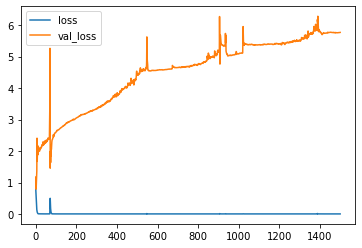

In [62]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["loss","val_loss"])
plt.show()

In [427]:
pred_binary = np.where(predictions > 0.5, 1, 0)

In [428]:
model.evaluate(X_test_tr, y_test)

623/623 [==============================] - ETA: 0s - loss: 0.7291 - acc: 0.312 - 0s 85us/sample - loss: 0.7045 - acc: 0.4944


[0.7045035697101207, 0.49438202]

In [63]:
predictions = model.predict(X_test_tr)
plt.plot(predictions.flatten())
plt.plot(y_test)

NameError: name 'model' is not defined

In [335]:
# create the LSTM model
n_steps = 120
n_features = 768
model = Sequential()
#model.add(CuDNNLSTM(200, input_shape=(None, n_features), return_sequences= True))
model.add(Input((None, n_features)))
model.add(Bidirectional(LSTM(200, return_sequences = True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(Dense(1, activation='elu'))
model.compile(loss='mae', optimizer='adam')
print(model.summary())


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, None, 400)         1550400   
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 50)          20050     
_________________________________________________________________
dense_36 (Dense)             (None, None, 1)           51        
Total params: 1,570,501
Trainable params: 1,570,501
Non-trainable params: 0
_________________________________________________________________
None


In [227]:
# create the Dense Model

n_features = 768
model = Sequential()
model.add(Input(n_features))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(200, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["acc"])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 200)               153800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 201       
Total params: 194,201
Trainable params: 194,201
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
def my_own_pad_sequence(array, maxlen):
    X_tr = []
    for x in array:
        length =  x.shape[0]
        if length > maxlen:
            X_tr.append(x[:maxlen])
        else:
            pad_diff = maxlen - length
            x = np.vstack((x, np.zeros([pad_diff,x.shape[1]])))
            X_tr.append(x)
    return np.array(X_tr)    
    

In [18]:
# X and y for one sequence per day
maxlen = 3000
X_train_tr = my_own_pad_sequence(train_bert_concat_articles, maxlen)
X_test_tr = my_own_pad_sequence(test_bert_concat_articles, maxlen)
y_train = train_labels
y_test = test_labels

# DRAFTS

In [32]:

train_labels = df_diff["BTC-USD"].loc[:"2019-12-31"]
test_labels = df_diff["BTC-USD"].loc["2020-01-01":]
train_labels = train_labels[pd.DatetimeIndex(train_sentences.groupby(train_sentences.index).count().index)]
test_labels = test_labels[pd.DatetimeIndex(test_sentences.groupby(test_sentences.index).count().index)]
assert test_labels.shape == test_bert_concat_articles.shape
assert train_labels.shape == train_bert_concat_articles.shape

In [585]:
d = np.arange(10000).reshape(100,5,2,2,5)
d.strides

(400, 80, 40, 20, 4)

In [611]:
result = np.array([])   
for i in range(0,10):
    result = np.append(result, np.array([i]*5))
result = result.reshape(10,5)
rolling_window_bert_2nd_dim(result,8)

In [10]:
def rolling_window_bert_2nd_dim(a, window):
    shape = (a.shape[0] - window + 1, window, a.shape[1])
    strides = (a.strides[0], a.strides[1]*a.shape[1], a.strides[1])
    #print(shape, strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [92]:
#window = 100
#X_train = [rolling_window_bert_2nd_dim(element, window) for element in train_bert_concat_articles]
#X_test = [rolling_window_bert_2nd_dim(element, window) for element in test_bert_concat_articles]
#y_train = train_labels
#y_test = test_labels

In [102]:

#X_train_tr= pad_sequences(train_bert_concat_articles, maxlen=maxlen, padding='post', truncating='post')

In [155]:
X_train_tr = my_own_pad_sequence(train_bert_concat_articles, maxlen)
X_test_tr = my_own_pad_sequence(test_bert_concat_articles, maxlen)

In [82]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 5000
X_train_tr= pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_tr= pad_sequences(X_test, maxlen=maxlen, truncating='post')



(array([  5.,  46., 104., 109.,  50.,  22.,  19.,   5.,   1.,   1.,   1.,
          0.,   0.,   0.,   1.]),
 array([ 1478.        ,  2177.26666667,  2876.53333333,  3575.8       ,
         4275.06666667,  4974.33333333,  5673.6       ,  6372.86666667,
         7072.13333333,  7771.4       ,  8470.66666667,  9169.93333333,
         9869.2       , 10568.46666667, 11267.73333333, 11967.        ]),
 <a list of 15 Patch objects>)

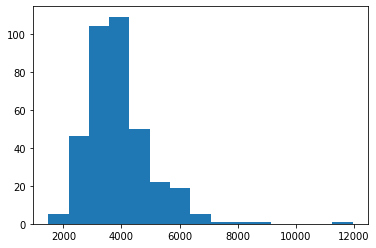

In [63]:
plt.hist(lengths, bins = 15,)